In [1]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import robot_visualize as rbvis



In [2]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/train_act_scara_pick_onefruit_block/fruit_block_aug2/"

config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_150000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]

print("loading ACT policy success")

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/zfei/software/robomimic/robomimic/scripts/setup_macros.py
)
{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist', 'wrist_down'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
ACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist', 'wrist_down'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', ta

/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future

Use VQ: False, None, None
number of parameters: 95.07M
KL Weight 10
loading ACT policy success


In [40]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def pre_process_multi_img(curr_images):
    # a list of images [w, h, 3]
    curr_image = np.stack(curr_images, axis=0)
    img_torch = torch.from_numpy(curr_image)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def post_process_all_actions(all_actions):
    # post process all actions
    joint_states_traj = []
    actual_actions = []
    for i, raw_action in enumerate(all_actions):
        actual_action = post_process_action(raw_action)
        actual_actions.append(actual_action)
    actual_actions = np.asarray(actual_actions)
    # print(actual_actions)
    return actual_actions


In [43]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../hitbot_model.urdf")
print("ok: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 
                     0.0, 0.0, 429.129150390625, 242.32749938964844, 
                     0.0, 0.0, 0.0, 1.0, 0.0]]).reshape([3, 4])
rgb_p

ok:  True


array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [98]:
h5data_file = "/mnt/data1/act/train_act_scara_pick_onefruit_block/data1/episode_14.hdf5"
h5data_file = "/mnt/data1/act/train_act_scara_pick_onefruit_block/data_aug2/episode_14.hdf5"
h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_updown_pick_one/2024-03-19_09-10-17-up-down-cam/2024-03-19_09-10-17-up-down-cam/episode_0.hdf5"
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_wrist_up_np = root["/observations/images/wrist"][index]
        img_wrist_down_np = root["/observations/images/wrist_down"][index]
        qpos_all =  root["/observations/qpos"][()]

        print("img_wrist_up_np: ",img_wrist_up_np.shape)
        curr_images = [img_wrist_up_np, img_wrist_down_np]

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_images_torch = pre_process_multi_img(curr_images)
        # print("qpos: ",qpos.shape)
        all_actions = policy(qpos, curr_images_torch)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)


action_obs_np = action_obs_np[index:]
qpos_all = np.asarray(qpos_all)
qpos_all = qpos_all[index:]


img_wrist_up_np:  (480, 640, 3)
all_actions:  (100, 5)
action_obs_np:  (232, 5)


In [99]:
image_actions_list = []
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        for index in range(0, len(action_obs_np)):
            qpos_np = root["/observations/qpos"][index]
            img_wrist_up_np = root["/observations/images/wrist"][index]
            img_wrist_down_np = root["/observations/images/wrist_down"][index]
            curr_images = [img_wrist_up_np, img_wrist_down_np]
            qpos = pre_process_qpos(qpos_np)
            curr_images_torch = pre_process_multi_img(curr_images)
            all_actions = policy(qpos, curr_images_torch)
            all_actions = all_actions.squeeze(0).cpu().numpy()
            image_actions_list.append([img_wrist_up_np.copy(), all_actions])

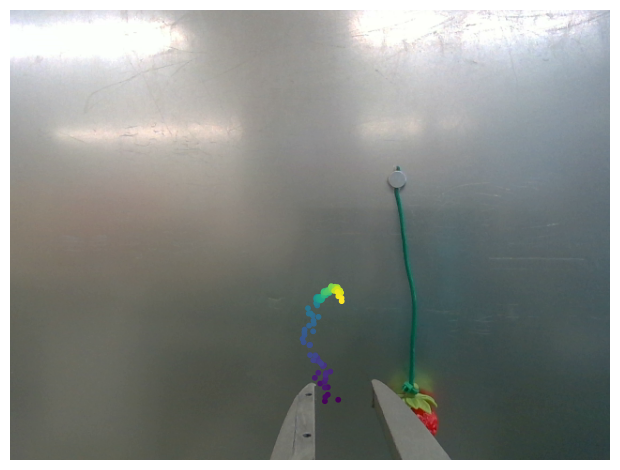

In [100]:
img_plot, all_actions = image_actions_list[0]
actual_actions = post_process_all_actions(all_actions)
vis_actions = actual_actions # Predicted action
# vis_actions = action_obs_np # Ground truth action
# vis_actions = qpos_all # Ground truth qpos


rbvis.paint_action_in_image(img_plot, vis_actions, rgb_p, fk_solver, chain, save_path=None)

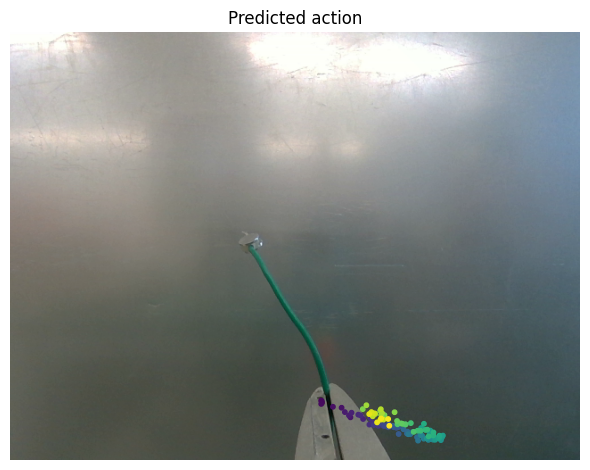

In [101]:
fig, ax = plt.subplots()  # Create a single figure and axis
plt_fig_ax = [fig, ax]
title = "Predicted action"
# title = "Ground truth action"
vis_len = 100

for i in range(0, len(action_obs_np)):
    img_plot, all_actions = image_actions_list[i]
    actual_actions = post_process_all_actions(all_actions)
    vis_actions = actual_actions # Predicted action
    # if i + vis_len >= len(action_obs_np):
    #     break
    # vis_actions = action_obs_np[i:i+vis_len] # Ground truth action
    # vis_actions = qpos_all # Ground truth qpos
    rbvis.paint_action_in_image(img_plot, vis_actions, rgb_p, fk_solver, chain, save_path="./temp/%05i.jpg"%i, plt_fig_ax=plt_fig_ax, title=title)


# ffmpeg -pattern_type glob -i "*.jpg" -framerate 10 action_prediction.gif


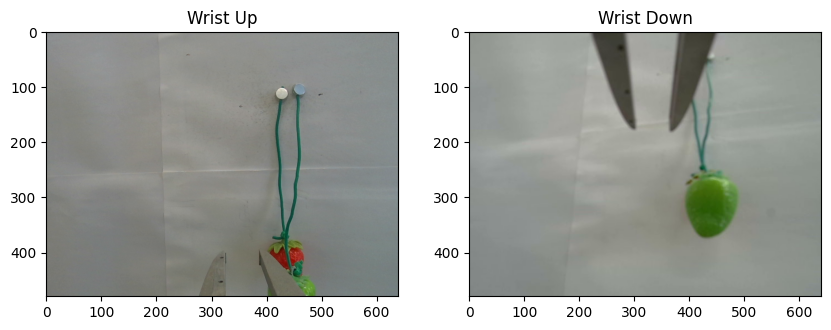

In [91]:
# plot image of wrist up and wrist down on left and right 

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Wrist Up')
plt.imshow(cv.cvtColor(img_wrist_up_np, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Wrist Down')
plt.imshow(cv.cvtColor(img_wrist_down_np, cv.COLOR_BGR2RGB))
plt.show()


In [92]:

actual_actions = post_process_all_actions(all_actions)

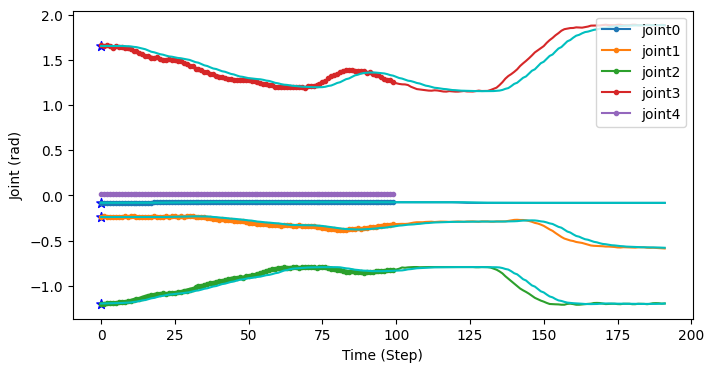

In [93]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')
steps_plot = np.arange(0, len(action_obs_np[:]), 1)
plt.plot(steps_plot, action_obs_np[:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[:, 3],  c="C%i"%(3 ), label='joint3')


steps_plot = np.arange(0, len(qpos_all[:]), 1)
plt.plot(steps_plot, qpos_all[:, 0],  c="c", label='joint0')
plt.plot(steps_plot, qpos_all[:, 1],  c="c", label='joint1')
plt.plot(steps_plot, qpos_all[:, 2],  c="c", label='joint2')
plt.plot(steps_plot, qpos_all[:, 3],  c="c", label='joint3')

In [24]:
# vis_actions = action_obs_np # Ground truth action
vis_actions = actual_actions # Predicted action
# vis_actions = qpos_all # Ground truth qpos
cam_poses, cam_poses_raw, link_poses_list = rbvis.get_camera_poses(vis_actions, fk_solver, chain)



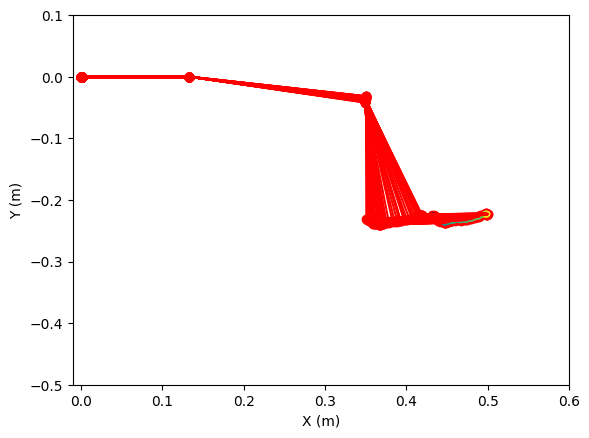

In [25]:
rbvis.plot_robot_2d_xy_batch(link_poses_list)
plt.scatter(cam_poses[:, 0], cam_poses[:, 1], c=range(len(cam_poses)), marker='.')
plt.show()

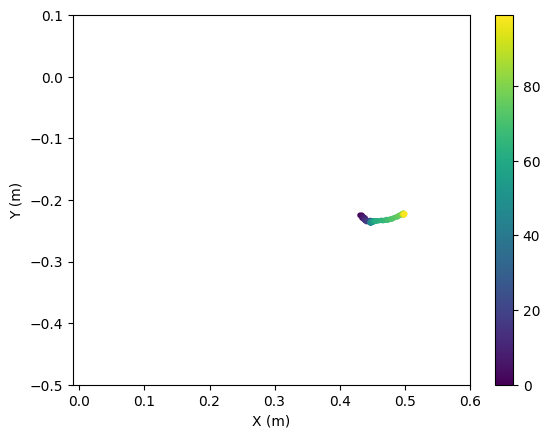

In [26]:
plt.scatter(cam_poses[:, 0], cam_poses[:, 1], c=range(len(cam_poses)), marker='.')
plt.ylim([-0.5, 0.1])
plt.xlim([-0.01, 0.6])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

<Figure size 1000x800 with 0 Axes>

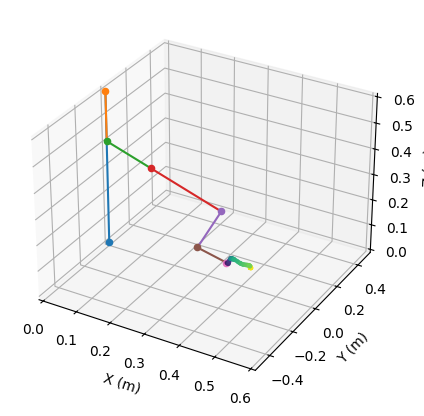

In [27]:
fig = plt.figure(figsize=(10, 8))
ax = rbvis.plot_robot(link_poses_list[0])

# plot ee_poses xyz
ax.scatter(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c=range(len(cam_poses)), marker='.')
ax.plot(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c='r')

ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

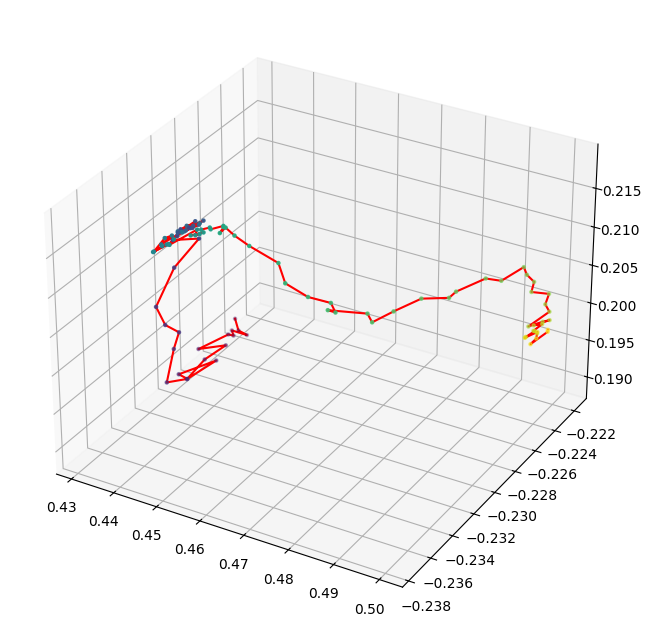

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# plot ee_poses xyz
ax.scatter(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c=range(len(cam_poses)), marker='.')
ax.plot(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c='r')


# ax.set_ylim([-0.5, 0.5])
# ax.set_zlim([0, 0.3])
# ax.set_xlim([0, 0.6])

ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

# Image Projection

In [29]:
cam_pts_init, cam_in_world_all_pos = rbvis.get_camera_in_world_and_init(cam_poses_raw)
cam_pts_init[0]

array([0., 0., 0.])

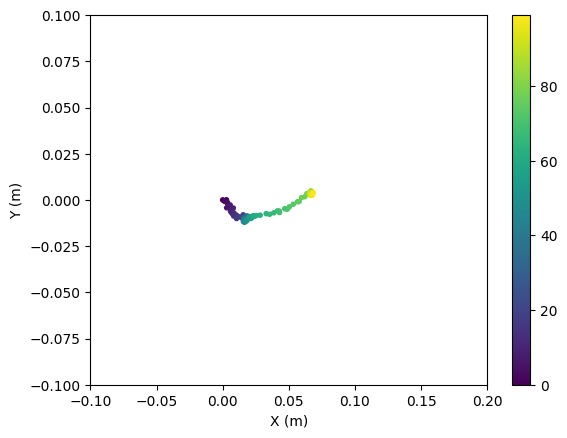

In [30]:
plt.scatter(cam_pts_init[:, 0], cam_pts_init[:, 1], c=range(len(cam_pts_init)), marker='.')
# plt.scatter(pts_init[:, 0], pts_init[:, 1], c=range(len(pts_init)), marker='.')
plt.ylim([-0.1, 0.1])
plt.xlim([-0.1, 0.2])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

In [33]:
# cam_pts_init to ee_pts_cam (ee_pts_init, init is the same as cam)
camera_T_ee = trans.states2SE3([0.12, -0.008, -0.0485, 0, 0, 0])
ee_pts_cam = camera_T_ee.dot(trans.xyz2homo(cam_pts_init).T).T[:,: 3]
ee_pts_cam[0]


array([ 0.12  , -0.008 , -0.0485])

In [36]:
ee_pts_opt = rbvis.pts_cam_to_opt(ee_pts_cam)
uvs = proj.project_point_to_image(ee_pts_opt, rgb_p)


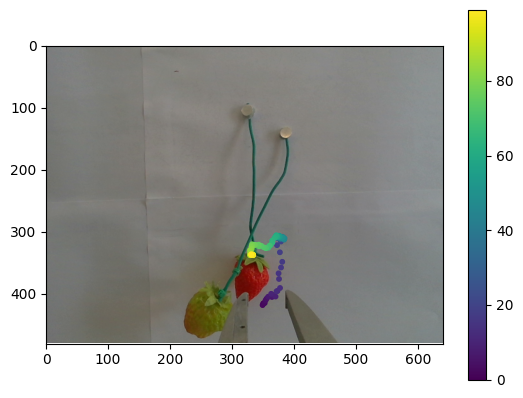

In [37]:

img_plot = img_wrist_up_np.copy()

plt.imshow(cv.cvtColor(img_wrist_up_np, cv.COLOR_BGR2RGB))
plt.scatter(uvs[:, 0], uvs[:, 1], c=range(len(uvs)), s=10)
# limit the axis to the image shape
plt.xlim([0, img_wrist_up_np.shape[1]])
plt.ylim([img_wrist_up_np.shape[0], 0])
plt.colorbar()